In [249]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

In [250]:
#from numpy import genfromtxt
#my_data = genfromtxt('train.csv', delimiter=',', usecols=np.arange(0,12))
train_data = pd.read_csv('train.csv', delimiter=',')
test_data = pd.read_csv('test.csv', delimiter=',')

In [364]:
'''
Checklist for data analysis
[] Data cleaning
    [X] Data splitting and cleaning out unusable value
    [X] Specific data cleaning for certain model (maybe)
[] Model analysis
    [X] Logistic Regression
        80 % accuracy without cross validation for hyper parameter
        82 % from scikit with L2 regression with default parameter
    [] Nearest Neighbor
    [] Support Vector Machine
    [] Decision Tree analysis 
        [] Ensemble method
        [] Random forest (bagging)
[] cross validation and model tunning --> WIP
    [] Data splitting method and analysis
    [] Hyper-Parameter analysis on certain models
[] Insight analysis
    [] Reverse engineering for missing data  --> WIP
        [] Re-run previous model to see improvement
[] Future work
Includes graphic to show the analysis of the data
'''

'\nChecklist for data analysis\n[] Data cleaning\n    [X] Data splitting and cleaning out unusable value\n    [X] Specific data cleaning for certain model (maybe)\n[] Model analysis\n    [X] Logistic Regression\n        80 % accuracy without cross validation for hyper parameter\n        82 % from scikit with L2 regression with default parameter\n    [] Nearest Neighbor\n    [] Support Vector Machine\n    [] Decision Tree analysis \n        [] Ensemble method\n        [] Random forest (bagging)\n[] cross validation and model tunning --> WIP\n    [] Data splitting method and analysis\n    [] Hyper-Parameter analysis on certain models\n[] Insight analysis\n    [] Reverse engineering for missing data  --> WIP\n        [] Re-run previous model to see improvement\n[] Future work\nIncludes graphic to show the analysis of the data\n'

In [251]:
def split_data(data, percent):
    train_size = len(data) * percent * 0.01
    train_size = int(train_size)
    return data.iloc[:train_size, :], data.iloc[train_size:, :]

In [252]:
'''
Turning catagory value using 1 hot and convert binary to 0/1 value
Inital experiement, dropping name and ticket where it makes linear regression easier
The cluster analysis should include such features to increase information gain
''' 
def clean_linear_reg (train_data):
    temp = train_data.copy()
    #Features to modify or drop
    temp.loc[:,'Cabin'] = temp['Cabin'].apply(lambda x : str(x)[:1])
    temp.loc[:, 'Sex'] = temp['Sex'].apply(lambda x: 1 if x == "male" else 0)
    temp = temp.drop(['Name','Ticket', 'PassengerId'], 1)
    #temp = temp.drop('Ticket',1,)
    #temp = temp.drop('PassengerId', 1)
    #Apply one hot encoding for categorical data to analysis
    temp = pd.get_dummies(temp)
    #exclusive for titanic data
    temp['Age'].fillna(temp['Age'].mean(), inplace=True)
    cols = temp.columns.tolist()
    cols.pop(0)
    cols.append('Survived')
    temp = temp[cols]
    return temp

def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [253]:
clean_data = clean_linear_reg(train_data)
norm_data= normalize(clean_data)
clean_train_norm, clean_test_norm = split_data(norm_data,80)
#clean_train_norm = normalize(clean_data[0])
#clean_test_norm = normalize(clean_data[1])

In [265]:
print clean_train_norm.shape
print clean_test_norm.shape

(712, 19)
(179, 19)


In [ ]:
#Sigmod helper function for activation
def sigmod(x):
    if x < 0:
        return 1 - 1/(1+math.exp(x))
    else:
        return (1.0 / ( 1 + math.exp(-1 * x)))

f = []
#Batch approach using linear regression method
def batch_logistic_descent(data, step_size, tolerence, lambd, max_iteration=100, theta=None):
    m = data.shape[0]
    label = data.iloc[:,-1]
    if theta is None:
        theta = np.zeros(data.shape[1]-1, dtype=np.float)
        print theta
    for iteration in range (max_iteration+1):
        h= (data.iloc[:,:-1].dot(theta)).apply(lambda x: sigmod(x))
        
        grads = (1.0/m) * ((data.iloc[:,:-1].T.dot(h - label)) + ( float(lambd) /m * theta))
        print "shape of grads", grads.shape
        theta = theta - (step_size * grads)
        #print theta
        errors = np.linalg.norm(h)
        print "Error norm", errors
        loss = np.linalg.norm(grads)
        print "grads loss", loss
        f.append(loss)
        if iteration > max_iteration:
            break
    return theta            

In [ ]:
subset = clean_data[0]
#c = stochastic_gdescent(subset ,0.01,0.001, 1000)
d = batch_logistic_descent(subset, 1, 0.01, 1, 200)

In [ ]:
plt.plot(f)

In [ ]:
a.groupby('Survived').count()

In [ ]:
#stochastic approach using linear regression method
#Plot the value and compute for the average decision boundary of the survivor statstics
def stochastic_gdescent (data, step_size, tolerence, max_iters=10000, theta=None):
    label = data.iloc[:,-1]
    if theta is None:
        theta = np.zeros(data.shape[1]-1)
    for x in range(0, max_iters):
        print x
        i = np.random.randint(low=0, high=data.shape[0], size=None)
        error = theta.dot(data.iloc[i,:-1]) - label[i]
        print "Error ", error
        for y in range(0,len(theta)):
            delta_weight =  step_size * error * data.iloc[i,y]
            theta[y] = theta[y] - delta_weight
        #Report every 100 iteration to see the gradient and add data for plot
        if (x % 100 == 0) :
            #print "Data point of x" , x, " is ", data.iloc[i]
            print "Iteration", x
            print "Error in prediction at this point", error
            print "Current theta", theta
            #a[x/100] = (np.sum(data.dot(theta) - label **2)/10000) #error (normalize)
        if (error **2 < tolerence) and x > 200:
            print "Error reached termination condition"
            return theta

In [ ]:
subset = clean_data[0].iloc[:10]
#c = stochastic_gdescent(subset ,0.01,0.001, 1000)
d = batch_logistic_descent(subset, 0.01, 0.001, 10)

In [ ]:
print d

In [336]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [337]:
model = LogisticRegression()
model.fit(clean_train_norm.iloc[:,:-1], clean_train_norm.iloc[:,-1])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [354]:
model.score(clean_test_norm.iloc[:,:-1], clean_test_norm.iloc[:,-1])

0.82122905027932958

In [261]:
#Sigmod helper function for activation
def sigmod(x):
    if x < 0:
        return 1 - 1/ (1+math.exp(x))
    else:
        return (1.0 / ( 1 + math.exp(-1 * x)))

'''
The logistic regression classifier fits default using L2 regularization
Lamba and alpha are the hyper parameter to control the regularization and convergence rate
The train data and label data can be any data type (numpy, panda.dataframe)
'''
def logistic_regression_fit (train_data, label, max_iterations, lamda, verbose=False, 
                         theta=None, threshold=0.001, alpha=0.01):
    convergence_rate = []
    if theta is None:
        theta = np.zeros(train_data.shape[1], dtype=np.float)
    n = train_data.shape[1] #size of the data
    m = train_data.shape[0] #number of the features
    for iteration in range(0, max_iterations):
        hx = train_data.dot(theta).apply(lambda x: sigmod(x))
        #print "hx is ", hx
        gradient = (1.0/m) * train_data.T.dot(hx - label) + (float(lamda)/m * theta)
        #print "gradient", gradient
        theta = theta - (alpha * gradient)
        
        loss = np.linalg.norm(gradient)
        convergence_rate.append(loss)
        if loss < threshold:
            break;
    '''
    Plot and visualization of the converence rate. Verbose option will trigger this output
    '''
    if verbose is True:
        print "Total Iteration: ", iteration
        print "Final loss: ", loss
        plt.plot(convergence_rate)
    return theta, loss

Total Iteration:  9999
Final loss:  0.0123302305159


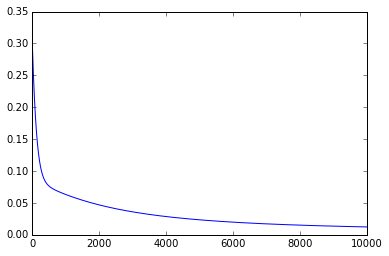

In [361]:
parameter, loss = logistic_regression_fit(clean_train_norm.iloc[:,:-1], clean_train_norm.iloc[:,-1], 10000, 1,
                                      verbose=True, threshold=0.01)

In [366]:
def score (X, Y, weight):
    '''
    Helper function to score the accuracy of the model
    
    Parameters
    ----------
    X : array-like, shape = (n_samples, n_features)
        Test samples.

    y : array-like, shape = (n_samples,)
        True labels for X.

    Returns
    -------
    out : float
        Accuracy of the model in %.
    '''
    
    prediction = X.dot(weight).apply(lambda x: 1 if sigmod(x) > 0.5 else 0)
    error_count = 0.0
    for x in range(0, Y.shape[0]):
        if prediction.iloc[x] != Y.iloc[x]:
            error_count += 1
    error = (1 - (error_count / float(m)))
    print error
    return error

In [370]:
print clean_test_norm.shape
print parameter.shape
f = score(clean_test_norm.iloc[:,:-1], clean_test_norm.iloc[:,-1], parameter)
print f

(179, 19)
(18,)


NameError: global name 'm' is not defined